# MobileNet-224px - Data Augmentation Manual


## Activa GPU rey, desde notebooks settings

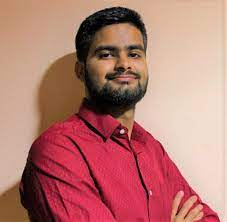


## Librerias

Instalar roboflow e importar el resto de las librerias.

Tip: luego de correr pip install roboflow, apretar en la cruz que sale para ocultar el output horrible.


In [1]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 913.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c527b0f8aed3d9236dc73aac39d8d679ef596b27f66a6ca2bb55e148b986fb0a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      S

In [ ]:
import numpy as np
import cv2
from keras.applications.mobilenet import MobileNet
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import pandas as pd
from roboflow import Roboflow
from keras import callbacks
from google.colab.patches import cv2_imshow

## RoboFlow

Importar datos utilizando la API de roboflow: esto viene del export que sale de RoboFlow, seleccionando metodo de export "code" y "multiclass"


In [ ]:
rf = Roboflow(api_key="RIRyho5TtyNxqxJqhn2s")
project = rf.workspace("fall-detection-nzoyh").project("fall-detection-bb")
dataset = project.version(9).download("multiclass")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to fall-detection-bb-9 in multiclass:: 100%|██████████| 2411/2411 [00:00<00:00, 3268.88it/s]


Guardamos la version


In [ ]:
version = int(dataset.version)
version

9

Funcion **move to folder**:

Generar las carpetas fall y no fall y meter las imagenes donde correspondan segun lo que dicen los CSV


In [ ]:
import os
import shutil
import pandas as pd


def move_to_folders(version, folder):
    # Define the paths
    image_folder = f"/content/fall-detection-bb-{version}/{folder}"
    csv_file = f"/content/fall-detection-bb-{version}/{folder}/_classes.csv"
    output_folder = f"/content/fall-detection-bb-{version}/{folder}"

    # Read the CSV file
    data = pd.read_csv(csv_file)
    data["label"] = ["fall" if x == 1 else "no fall" for x in data[" fall"]]

    # Create folders for each label
    for label in ["fall", "no fall"]:
        folder_path = os.path.join(output_folder, label)
        os.makedirs(folder_path, exist_ok=True)

    # Move images to their corresponding folders
    for index, row in data.iterrows():
        image_name = row["filename"]
        label = row["label"]

        source_path = os.path.join(image_folder, image_name)
        destination_folder = os.path.join(output_folder, label)
        destination_path = os.path.join(destination_folder, image_name)

        # Move the image to the destination folder
        shutil.move(source_path, destination_path)

    print("Images moved successfully!")

Luego de correr esto, comprobar que en cada carpeta de train, test y valid ahora hay dos carpetas dentro, fall y no fall.


In [ ]:
move_to_folders(version, "train")
move_to_folders(version, "valid")
move_to_folders(version, "test")

Images moved successfully!
Images moved successfully!
Images moved successfully!


## Data Augmentation


In [ ]:
_, _, files = next(os.walk(f"/content/fall-detection-bb-{version}/train/fall"))
file_count1 = len(files)
_, _, files = next(os.walk(f"/content/fall-detection-bb-{version}/train/no fall"))
file_count2 = len(files)

file_count1 + file_count2

2036

Tarda 2 minutos


In [ ]:
import imgaug.augmenters as iaa


def augmentate_dataset(main_path):
    """Augmentation a imagenes originales, guardandolas en el mismo path."""

    fall_path = main_path + "/fall"
    no_fall_path = main_path + "/no fall"

    augmentations = [
        iaa.Grayscale(alpha=(0.8, 1.0), random_state=42),  # Convert images to grayscale
        iaa.Affine(
            rotate=(-15, 15), random_state=42
        ),  # Apply rotations between -15 and 15 degrees
        iaa.Multiply(
            (0.4, 0.55), random_state=42
        ),  # Adjust brightness by multiplying values
    ]

    for path in [fall_path, no_fall_path]:
        # Entrar a cada path
        for filename in os.listdir(path):
            image_path = os.path.join(path, filename)
            image = cv2.imread(image_path)

            # Aplicar transformacion y guardar fotos aumentadas
            for idx, augmentation in enumerate(augmentations):
                augmented_image = augmentation.augment_image(image)
                transformed_filename = f"{filename}_augmented_{idx}.jpg"
                cv2.imwrite(os.path.join(path, transformed_filename), augmented_image)

## Data Prep for Model


No hace falta tocar nada.

Lo que hace este paso es generar el formato dataset que luego tomara el modelo para entrenar y predecir.


In [ ]:
# Rutas de las carpetas de entrenamiento, validación y prueba
train_dir = f"/content/fall-detection-bb-{version}/train"
valid_dir = f"/content/fall-detection-bb-{version}/valid"
test_dir = f"/content/fall-detection-bb-{version}/test"

# Tamaño de redimensionamiento deseado
target_size = (224, 224)

# Augmentation
augmentate_dataset(train_dir)

# Definir la transformación de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalizar los valores de píxeles a [0, 1]
    preprocessing_function=lambda x: cv2.resize(x, target_size),
)

# Definir la transformación de datos para el conjunto de validación y prueba
valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255, preprocessing_function=lambda x: cv2.resize(x, target_size)
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255, preprocessing_function=lambda x: cv2.resize(x, target_size)
)

# Crear generadores de datos a partir de las carpetas
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,  # Tamaño de las imágenes de entrada
    batch_size=32,  # Tamaño del lote (batch)
    class_mode="binary",  # Modo de clasificación (categórica en este caso)
    classes=["no fall", "fall"],
    shuffle=False,
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=32,
    class_mode="binary",
    classes=["no fall", "fall"],
    shuffle=False,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode="binary",
    classes=["no fall", "fall"],
    shuffle=False,
)

Found 8144 images belonging to 2 classes.
Found 270 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


In [ ]:
8144 / 4

2036.0

In [ ]:
test_generator.class_indices

{'no fall': 0, 'fall': 1}

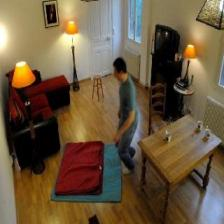

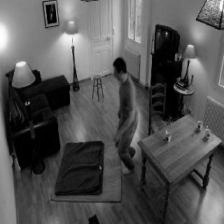

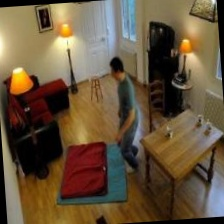

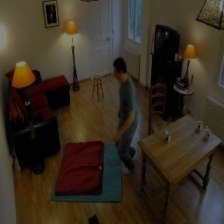

In [ ]:
img_paths = [
    f"/content/fall-detection-bb-{version}/train/fall/000006_jpg.rf.fe9b915f751856310eb82f1549df4ae3.jpg",
    f"/content/fall-detection-bb-{version}/train/fall/000006_jpg.rf.fe9b915f751856310eb82f1549df4ae3.jpg_augmented_0.jpg",
    f"/content/fall-detection-bb-{version}/train/fall/000006_jpg.rf.fe9b915f751856310eb82f1549df4ae3.jpg_augmented_1.jpg",
    f"/content/fall-detection-bb-{version}/train/fall/000006_jpg.rf.fe9b915f751856310eb82f1549df4ae3.jpg_augmented_2.jpg",
]

for img_path in img_paths:
    image = cv2.imread(img_path)
    cv2_imshow(image)

## Define model


En este ejemplo cargamos el modelo MobileNet, con los pesos del dataset imagenet.


In [ ]:
def load_MobileNet():
    base_model = MobileNet(
        weights="imagenet", include_top=False, input_shape=(224, 224, 3)
    )

    for layer in base_model.layers:
        layer.trainable = False

    return base_model


base_model = load_MobileNet()

17225924/17225924 [==============================] - 2s 0us/step


Numero de clases: no tocar, estmaos haciendo binario

Capas densas, se puede tocar si se quiere


In [ ]:
num_classes = 2

model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

Compilar.


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC()],
)

Visualizar


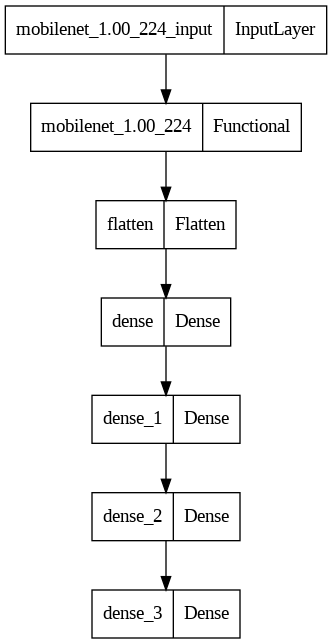

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                        

Preparamos todo para poder guardar el mejor modelo en drive. Darle OK cuando te salte la ventana emergente.


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
if not os.path.isdir("/content/gdrive/MyDrive/bestmodels"):
    print("creando best model para vos bebe")
    os.makedirs("/content/gdrive/MyDrive/bestmodels")
else:
    print("ya existe la carpeta, good")

ya existe la carpeta, good


Preparar callbacks de early stopping y de best model.

!!! Cambiar el nombre del modelo a algo propio


In [ ]:
es_callback = callbacks.EarlyStopping(monitor="val_auc", patience=10, verbose=1)

model_input = input()
model_name = f"{model_input}.h5"  # MODIFICAR CON LO PROPIO

mc_callback = callbacks.ModelCheckpoint(
    filepath=f"/content/gdrive/MyDrive/bestmodels/{model_name}",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
)

mobilenet-biggertest


Ejecutar


In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=[es_callback, mc_callback],
)

Epoch 1/100
255/255 [==============================] - 29s 69ms/step - loss: 1.8455 - auc: 0.8553 - val_loss: 1.0320 - val_auc: 0.7423
Epoch 2/100
255/255 [==============================] - 17s 67ms/step - loss: 0.3370 - auc: 0.9599 - val_loss: 0.4744 - val_auc: 0.8664
Epoch 3/100
255/255 [==============================] - 21s 82ms/step - loss: 0.1153 - auc: 0.9923 - val_loss: 0.5155 - val_auc: 0.8772
Epoch 4/100
255/255 [==============================] - 17s 68ms/step - loss: 0.1280 - auc: 0.9902 - val_loss: 0.4122 - val_auc: 0.9218
Epoch 5/100
255/255 [==============================] - 16s 61ms/step - loss: 0.0731 - auc: 0.9965 - val_loss: 0.4225 - val_auc: 0.9126
Epoch 6/100
255/255 [==============================] - 17s 67ms/step - loss: 0.0864 - auc: 0.9947 - val_loss: 0.3323 - val_auc: 0.9271
Epoch 7/100
255/255 [==============================] - 15s 59ms/step - loss: 0.0529 - auc: 0.9982 - val_loss: 1.4195 - val_auc: 0.8178
Epoch 8/100
255/255 [==============================] - 

## Resultados


Cargar best model


In [ ]:
best_model = tf.keras.models.load_model(
    f"/content/gdrive/MyDrive/bestmodels/{model_name}"
)

Insight de resultados


In [ ]:
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
predictions = best_model.predict(test_generator)
preds = np.round(predictions).flatten()

4/4 [==============================] - 1s 134ms/step


Accuracy y AUC de sklearn


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

print(f"Accuracy en test: {accuracy_score(true_labels,preds)}")
print(f"AUC en test: {roc_auc_score(true_labels,preds)}")

Accuracy en test: 0.8969072164948454
AUC en test: 0.9011261261261261


Ploteamos


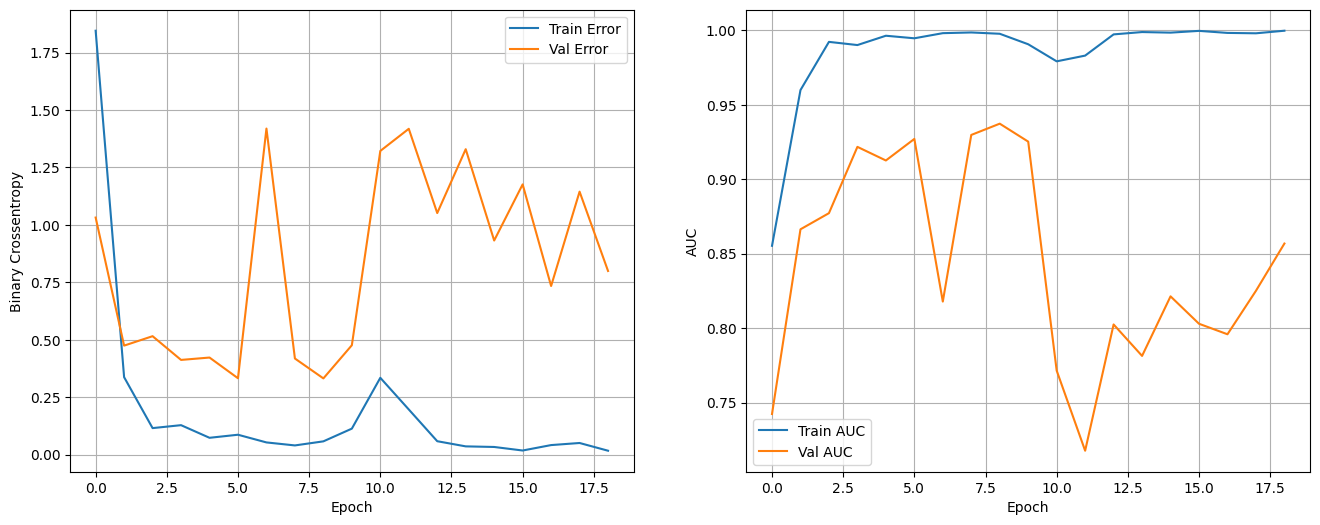

In [ ]:
def show_loss_auc_evolution(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Binary Crossentropy")
    ax1.plot(hist["epoch"], hist["loss"], label="Train Error")
    ax1.plot(hist["epoch"], hist["val_loss"], label="Val Error")
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("AUC")
    ax2.plot(hist["epoch"], hist["auc"], label="Train AUC")
    ax2.plot(hist["epoch"], hist["val_auc"], label="Val AUC")
    ax2.grid()
    ax2.legend()

    plt.show()


show_loss_auc_evolution(history)

Classification report


In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        60
           1       0.83      0.92      0.87        37

    accuracy                           0.90        97
   macro avg       0.89      0.90      0.89        97
weighted avg       0.90      0.90      0.90        97



Matriz de confusion


In [ ]:
import itertools


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.grid(False)

Confusion matrix, without normalization
[[53  7]
 [ 3 34]]


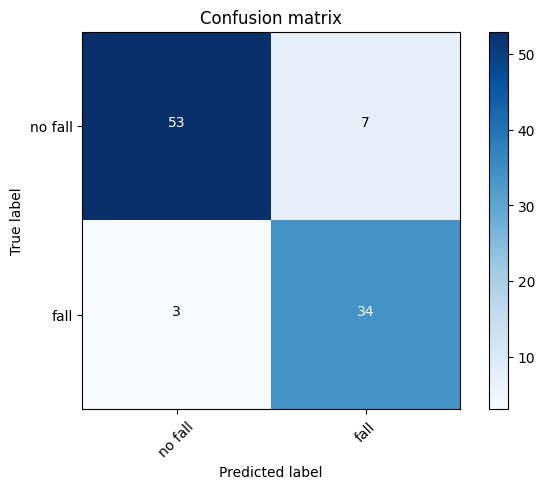

In [ ]:
class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(confusion_matrix(true_labels, preds), class_names)
plt.show()

## Ejemplos de errores


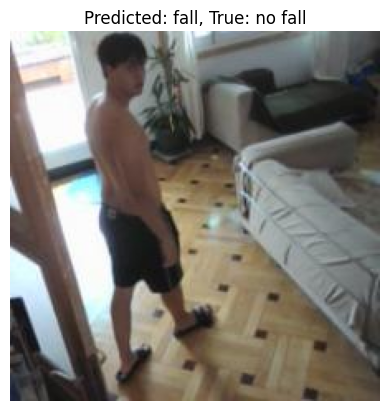

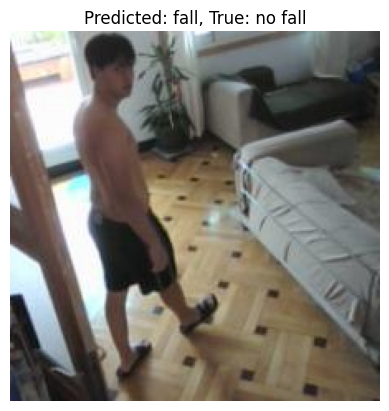

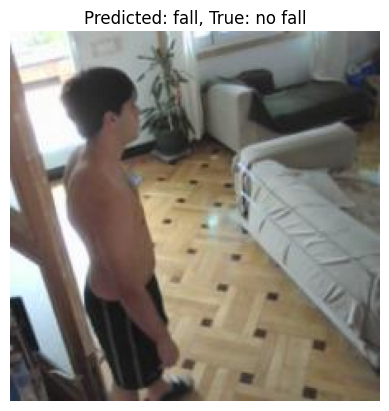

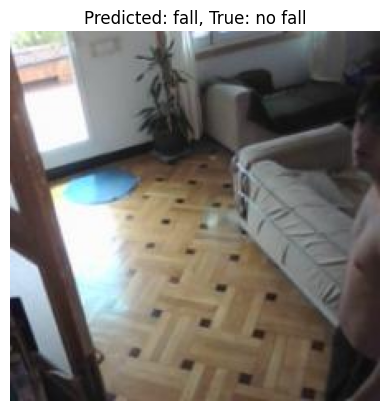

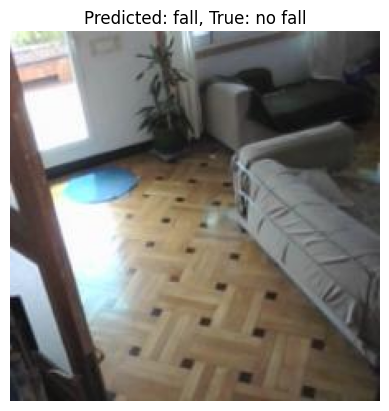

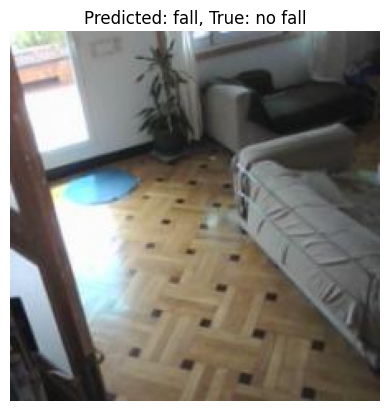

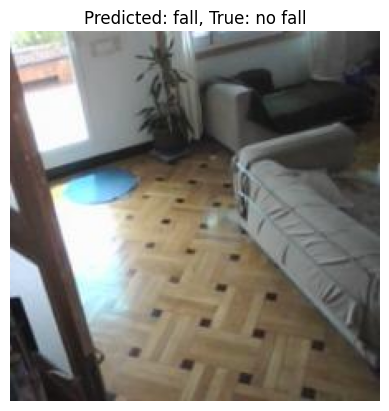

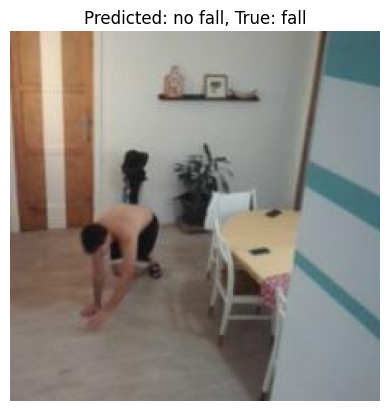

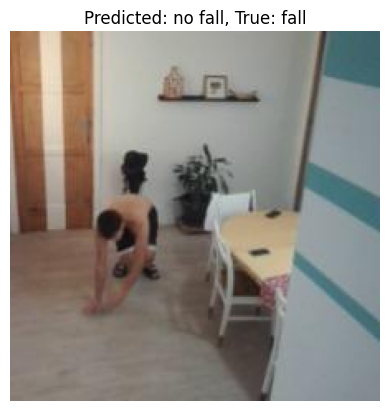

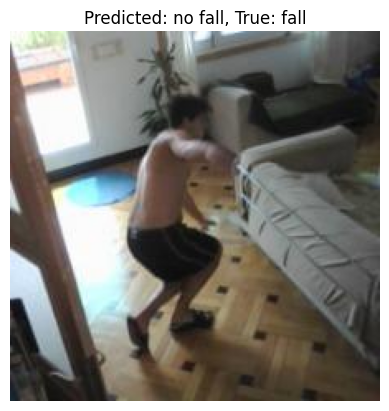

In [ ]:
# Recorre las imágenes de prueba y muestra cada una con su predicción y etiqueta real
for i in range(len(test_generator.filenames)):
    if class_names[int(preds[i])] != class_names[true_labels[i]]:
        image_path = test_dir + "/" + test_generator.filenames[i]
        image = plt.imread(image_path)

        plt.imshow(image)
        plt.title(
            f"Predicted: {class_names[int(preds[i])]}, True: {class_names[true_labels[i]]}"
        )
        plt.axis("off")
        plt.show()

    else:
        pass

## Probando en nuevas imagenes


In [ ]:
def preprocessImage(image, target_size):
    resized_image = cv2.resize(image, target_size)
    normalized_image = resized_image.astype(np.float32) / 255.0
    return normalized_image


def predictNewImage(image, threshold=0.5):
    image_processed = preprocessImage(image, target_size=(224, 224))
    prediction_example = best_model.predict(np.expand_dims(image_processed, axis=0))

    # Set a threshold for classifying as positive or negative
    threshold = 0.5

    # Convert the predicted probabilities to binary classes
    binary_preds = (prediction_example > threshold).astype(int)

    # Print the predicted class
    if binary_preds[0][0] == 1:
        print("The image is classified as Fall")
    else:
        print("The image is classified as No Fall")

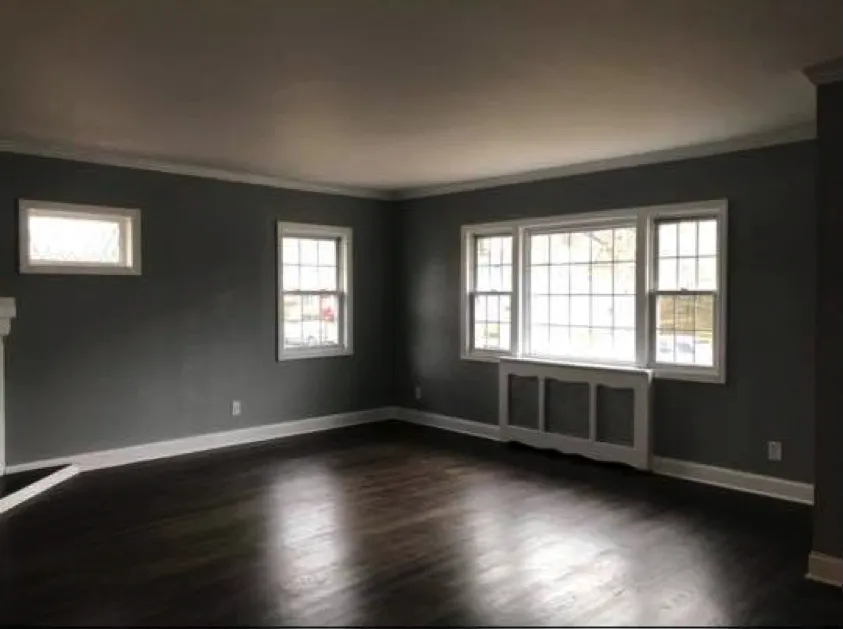

In [ ]:
img_path = "/content/empty_2.jpeg"
image = cv2.imread(img_path)
cv2_imshow(image)

In [ ]:
predictNewImage(image)

1/1 [==============================] - 1s 749ms/step
The image is classified as No Fall


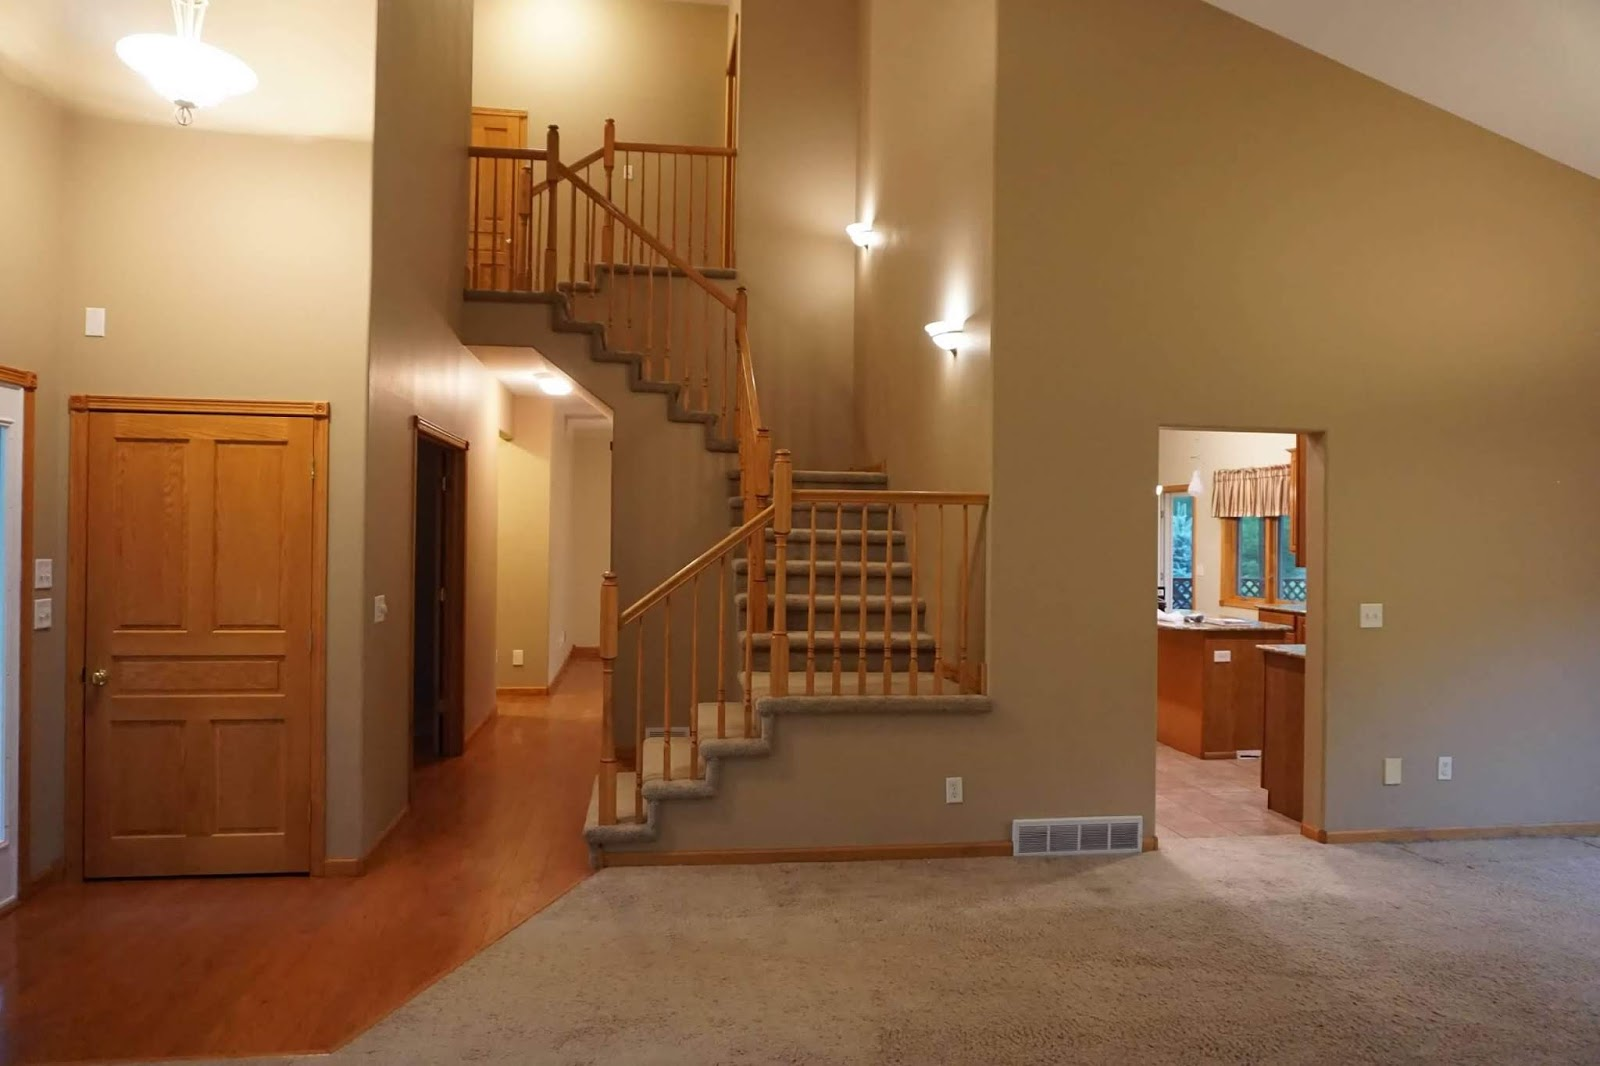

In [ ]:
img_path = "/content/empty_3.jpg"
image = cv2.imread(img_path)
cv2_imshow(image)

In [ ]:
predictNewImage(image)

1/1 [==============================] - 0s 24ms/step
The image is classified as No Fall


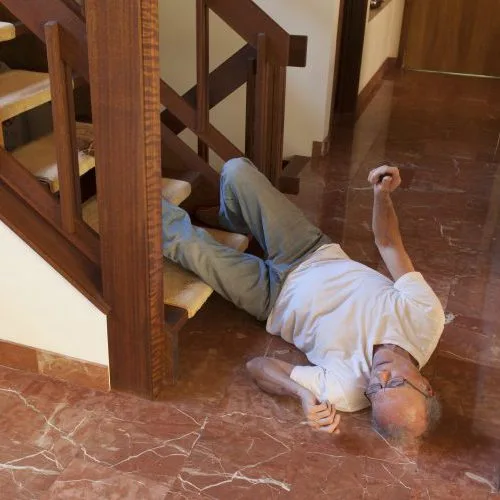

In [ ]:
img_path = "/content/example_2.jpg"
image = cv2.imread(img_path)
cv2_imshow(image)

In [ ]:
predictNewImage(image)

1/1 [==============================] - 0s 22ms/step
The image is classified as No Fall


## Checkpoint Modelo


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
best_model = tf.keras.models.load_model(
    f"/content/gdrive/MyDrive/bestmodels/aug_manual_mobilenet_224_ac.h5"
)

In [ ]:
def preprocessImage(image, target_size):
    resized_image = cv2.resize(image, target_size)
    normalized_image = resized_image.astype(np.float32) / 255.0
    return normalized_image


def predictNewImage(image, threshold=0.5):
    image_processed = preprocessImage(image, target_size=(224, 224))
    prediction_example = best_model.predict(np.expand_dims(image_processed, axis=0))

    # Set a threshold for classifying as positive or negative
    threshold = 0.5

    # Convert the predicted probabilities to binary classes
    binary_preds = (prediction_example > threshold).astype(int)

    # Print the predicted class
    if binary_preds[0][0] == 1:
        print("The image is classified as Fall")
    else:
        print("The image is classified as No Fall")

In [ ]:
img_path = "/content/IMG_20230719_184954.jpg"
image = cv2.imread(img_path)
predictNewImage(image)

1/1 [==============================] - 0s 23ms/step
The image is classified as Fall


In [ ]:
img_path = "/content/IMG_20230719_185002.jpg"
image = cv2.imread(img_path)
predictNewImage(image)

1/1 [==============================] - 0s 25ms/step
The image is classified as No Fall


In [ ]:
img_path = "/content/IMG_20230719_185015.jpg"
image = cv2.imread(img_path)
predictNewImage(image)

1/1 [==============================] - 0s 45ms/step
The image is classified as Fall


In [ ]:
img_path = "/content/IMG_20230719_185026.jpg"
image = cv2.imread(img_path)
predictNewImage(image)

1/1 [==============================] - 0s 67ms/step
The image is classified as Fall
